In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp profile

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis, moment
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
import math

from rough.data import *

In [ ]:
#| hide
from fastcore.test import *

To demonstrate, we're going to build on the data we processed in `data` 

In [ ]:
image = np.loadtxt('example.txt')
profiles = np.loadtxt('example_profiles.txt')

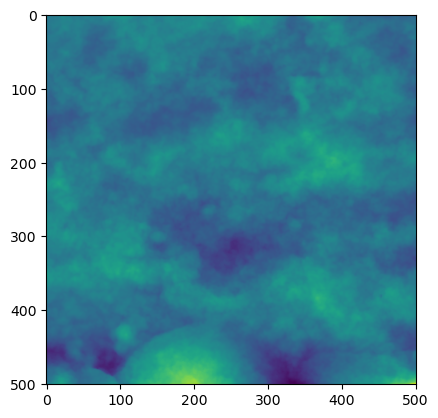

In [ ]:
plt.imshow(image)
plt.show()

## Statistical Parameters
The following methods are statistical in nature, providing a single number as a broad description of the distribution of the height values. 

In [ ]:
#| export
def Ra(im, #Numpy array or arraylike
       axis = 1, #Default to Ra of rows
       norm = True #Normalize the profile by subtracting the mean 
      ):
    '''
    Calculates Mean Absolute Roughness (Ra) along given axis. Defined as the average deviation of absolute height values from the mean line.
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.mean(np.absolute(im), axis = axis)

In [ ]:
#test_close(0.14539179526852036,Ra(cor2pgau,norm=False,axis=None),eps=1e-4)

In [ ]:
Ra(image)[:5]

array([0.00042559, 0.00041652, 0.00040715, 0.00039409, 0.00037837])

Remember, if you just want the parameters of a certain profile, you just index into your image and be mindful of the axis. 

In [ ]:
first_row_profile    = image[0,:]
first_column_profile = image[:,0]
Ra(first_column_profile, axis = 0)

0.0004406996100199229

In [ ]:
#| export
def Rms(im, #Numpy array or array like
        axis = 1, #Default to Rms of rows
        norm = True #Normalize the profile by subtracting the mean
       ):
    '''
    Calculates Root Mean Square Roughness (Rms) along given axis. Defined as the root mean square of deviations of height from the mean line of a given profile. 
    
    Also known as Rq
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.sqrt(np.mean(np.square(im), axis = axis))

In [ ]:
#test_close(0.195597300779425,Rms(cor2pgau,axis=None),1e-3)

In [ ]:
Rms(image)[:5]

array([0.00053041, 0.0005153 , 0.0004984 , 0.00048217, 0.00046463])

In [ ]:
#| export
def Rsk(im, #Numpy array or array like
         axis = 1, #Default to Skew of rows
         norm = True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the skew function
       ):
    '''
    Calcultes the Skew (Rsk) along given axis. Thin wrapper around scipy.stats.skew with bias set to False
    '''
    if norm:
        im = im - np.mean(im, axis=axis, keepdims=True)
    return skew(a = im, axis=axis, **kwargs)

In [ ]:
#test_close(1.094210880233907,Rsk(cor2pgau[50:-50],axis=None),1e-4)

In [ ]:
Rsk(image)[:5]

array([-0.33567068, -0.33327936, -0.33261958, -0.32251   , -0.28183241])

In [ ]:
#| export
def Rku(im, #Numpy array or array like
       axis = 1, #Default to Kurtosis of rows
       norm= True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the kurtosis function
       ):
    '''
    Calculates the Kurtosis (Rku) along given axis. This wrapper around scipy.stats.kurtosis 
    '''
    if norm:
        im = im - np.mean(im,axis=axis, keepdims=True)
    return kurtosis(a = im, axis = axis, **kwargs)

In [ ]:
#test_close(6.8550747244379355,Rku(cor2pgau,axis=None),1e-4)

In [ ]:
Rku(image)[:5]

array([-0.65026388, -0.70209278, -0.75579608, -0.75657439, -0.73669875])

In [ ]:
#| export
def Rp(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amax function
         ):
    '''
    Calculates the peak height of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.amax(im, axis = axis, **kwargs)
    

In [ ]:
#test_close(1.1930965342677724,Rp(cor2pgau,axis=None),1e-4)

In [ ]:
#| export
def Rv(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amin function
         ):
    '''
    Calculates the absolute max valley depth of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
        
    return abs(np.amin(im, axis = axis, **kwargs))

In [ ]:
#test_close(0.5760229498158181,Rv(cor2pgau,axis=None),1e-4)

In [ ]:
#| export
def Rz(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.ptp function
         ):
    '''
    Calculates the maximum height (max height + absolute max depth) of the profile. Synonymous with range. 
    Also called Rt
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    return np.ptp(im,axis = axis, **kwargs)

In [ ]:
#test_close(1.7691194840835909,Rz(cor2pgau,axis=None),1e-4)

In [ ]:
## Texture Parameters

In [ ]:
def local_max_min(im,
                  axis = 1,
                  norm = True,
                  **kwargs
                 ):
    ''' 
    Returns the number of local maxima and minima per unit length, also known as the density of extremes from Nayak (1971).
    Assumes the surface is random, with a gaussian distribution of heights (usually pretty safe). 
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    return (1/math.pi) * ((m4/m2)**(1/2))
    

In [ ]:
def Sds(im,
        axis = 1,
        norm = True,
        **kwargs
       ):
    '''
    Density of summits, as described by Nayak (1971).
    Assumes gaussian, isotropic surface. 
    '''
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    
    return (1 / (6 * math.pi * (3**(1/2)))) * (m4/m2)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()